<a href="https://colab.research.google.com/github/MerkulovDaniil/split-sgd/blob/master/Code/Continious_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install git+https://github.com/fastai/fastai --upgrade
!pip install git+https://github.com/fastai/fastprogress --upgrade
# from fastprogress.fastprogress import master_bar, progress_bar

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-yhtlqcum
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-yhtlqcum
  Created wheel for fastai: filename=fastai-1.0.61.dev0-cp36-none-any.whl size=237840 sha256=0eb3782866108a478f08d26cfe43483b7b277dacebafc48de00a392623bd3a16
  Stored in directory: /tmp/pip-ephem-wheel-cache-qdnya8gk/wheels/83/30/a0/6fa8a74c9f5a5ab45cdc84e9f9ed56d8a72750e11ebf50a364
Successfully built fastai
  Found existing installation: fastai 1.0.61.dev0
    Uninstalling fastai-1.0.61.dev0:
      Successfully uninstalled fastai-1.0.61.dev0
  Cloning https://github.com/fastai/fastprogress to /tmp/pip-req-build-ifqruuot
  Running command git clone -q https://github.com/fastai/fastprogress /tmp/pip-req-build-ifqruuot
  Created wheel for fastprogress: filename=fastprogress-0.2.3-cp36-none-any.whl size=12049 sha256=9a297b2241a6b3ead281a588f66f0b5ef7f57db289712ab08603e43843a47e08
  Stored in directory: /tmp/pip-ephem-wheel-ca

# General splitting and balancing

## Linear regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  0%|          | 3/7000 [00:00<04:45, 24.54it/s]

QR finished
🤖 GF trajectory started


100%|██████████| 7000/7000 [08:30<00:00, 13.71it/s]


🤖 GF trajectory finished
🤖 SGD trajectory started
🤖 SGD trajectory finished
🤖 Splitting I trajectory started
🤖 Splitting I trajectory finished
🤖 Splitting II trajectory started
🤖 Splitting II trajectory finished


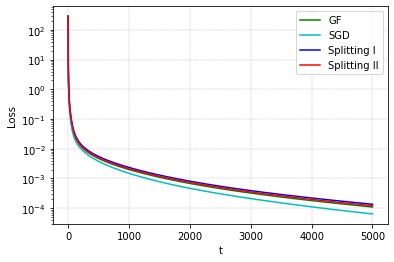

In [0]:
# ======= Libraries =======
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm, qr
import copy
from fastprogress.fastprogress import master_bar, progress_bar

# ======= Function definitions =======

def generate_problem(p, n, lstsq=False, epsilon = 0):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + epsilon*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q, R, theta_0, y_batch, h, n):
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n*np.linalg.norm(X @ theta - y)**2
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s

        loss = 0
        for i_batch in range(s):
            loss += 1/n*np.linalg.norm(X[i_batch] @ theta - y[i_batch])**2
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')


def gradient(X, theta, y):
    n, p = X.shape
    return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, lr):
    theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
    return theta

def relative_error(theta, thetalstsq=0):
    p = len(theta)
    if np.linalg.norm(thetalstsq) != 0:
        return(np.linalg.norm(theta - thetalstsq)/np.linalg.norm(thetalstsq))
    else:
        return(np.linalg.norm(theta - np.ones(p))/np.linalg.norm(np.ones(p)))

def logarithmic_norm(A):
    w,v = np.linalg.eig((A + A.T)/2)
    return(max(w))

def gradient_flow_trajectory(Q, R, theta_0, y, ts):
    p, n = Q.shape
    print('🤖 GF trajectory started')
    thetas = []
    losses = []

    for t in progress_bar(ts):
        # print(t)
        theta_t = solve_local_problem(Q, R, theta_0, y, t, n)
        thetas.append(theta_t)
        loss_t = loss(R.T@Q.T, theta_t, y)
        losses.append(loss_t)
    
    print('🤖 GF trajectory finished')

    return thetas, losses

def sgd_trajectory(Xs, theta_0, ys, lr, N_epoch):
    print('🤖 SGD trajectory started')
    s, b, p = Xs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    for i_t in progress_bar(range(N_epoch)):
        h = lr*n/b
        t+=h
        ts.append(t)
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)

        for i_batch in range(s):
            theta_t = make_SGD_step(Xs[i_batch], theta_t, ys[i_batch], lr)

    thetas.append(theta_t)
    loss_t = loss(Xs, theta_t, ys)
    losses.append(loss_t)  
    
    print('🤖 SGD trajectory finished')

    return thetas, losses, ts

def spl_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting I trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            # ts_new.append(ts[i_t] + i_batch*h/s)
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_prev = theta_t
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h, n)
            # print(np.linalg.norm(theta_t - theta_prev))
       
    
    print('🤖 Splitting I trajectory finished')

    return thetas, losses

def spl2_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting II trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        # print(h)
        for i_batch in range(s-1):
            # ts_new.append(ts[i_t] + i_batch*h/(2*s))
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
        
        # ts_new.append(ts[i_t] + h/(*s))
        # thetas.append(theta_t)
        # loss_t = loss(Xs, theta_t, ys)
        # losses.append(loss_t)
        theta_t = solve_local_problem(Qs[s-1], Rs[s-1], theta_t, ys[s-1], h, n)

        for j_batch in range(s-1):
            i_batch = s - (j_batch + 2) 
            # ts_new.append(ts[i_t] + j_batch*h/(2*s))
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
    
    print('🤖 Splitting II trajectory finished')

    return thetas, losses

# ======= Problem generation =======

p = 300
n = 300
s = 10
b = 30
epsilon = 0

X, theta_0, y, theta_lstsq = generate_problem(p,n, lstsq=True, epsilon=epsilon)

Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')

theta_0     = np.random.randn(p)
theta_0     = theta_0/np.linalg.norm(theta_0)
total_time  = 5000
learning_rate = 5e-2
h_size = 0.75
N_epochs = int(total_time*b/(learning_rate*n))
ts_gf = np.linspace(0, total_time, int(total_time/(h_size)))
ts_spl = np.linspace(0, total_time, int(total_time/(h_size)))

# ======= Trajectory generation =======
thetas_gf, losses_gf    = gradient_flow_trajectory(Q, R, theta_0, y, ts_gf)
thetas_sgd, losses_sgd, ts_sgd  = sgd_trajectory(Xs, theta_0, ys, learning_rate, N_epochs)
thetas_spl, losses_spl = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
thetas_spl2, losses_spl2 = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)

🤓 Spline interpolation for GF
🤓 Spline interpolation for SGD
🤓 Spline interpolation for Splitting I
🤓 Spline interpolation for Splitting II


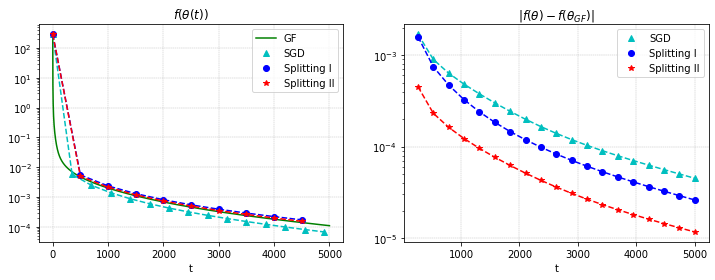

In [0]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between x.min and x.max
print('🤓 Spline interpolation for GF')
x_gf = ts_gf
y_gf = losses_gf

xnew = np.linspace(min(x_gf), max(x_gf), 20) 

spl_gf = make_interp_spline(x_gf, y_gf, k=3)
y_gf_smooth = spl_gf(xnew)

print('🤓 Spline interpolation for SGD')
x_sgd = ts_sgd
y_sgd = losses_sgd

spl_sgd = make_interp_spline(x_sgd, y_sgd, k=3)
y_sgd_smooth = spl_sgd(xnew)

print('🤓 Spline interpolation for Splitting I')
x_spl = ts_spl
y_spl = losses_spl

spl_spl = make_interp_spline(x_spl, y_spl, k=3) 
y_spl_smooth = spl_spl(xnew)

print('🤓 Spline interpolation for Splitting II')
x_spl = ts_spl
y_spl = losses_spl2

spl_spl = make_interp_spline(x_spl, y_spl, k=3)
y_spl2_smooth = spl_spl(xnew)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'go', label = 'True')
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'g')
axs[0].semilogy(ts_gf, losses_gf, 'g', label = 'GF')
axs[0].semilogy(ts_sgd[::700], losses_sgd[::700], 'c^', label = 'SGD')
axs[0].semilogy(ts_sgd[::700], losses_sgd[::700], 'c--')
axs[0].semilogy(ts_spl[::700], losses_spl[::700], 'bo', label = 'Splitting I')
axs[0].semilogy(ts_spl[::700], losses_spl[::700], 'b--')
axs[0].semilogy(ts_spl[::700], losses_spl2[::700], 'r*', label = 'Splitting II')
axs[0].semilogy(ts_spl[::700], losses_spl2[::700], 'r--')
axs[0].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[0].set_xlabel('t')
axs[0].set_title(r'$f\left(\theta(t)\right)$')
axs[0].legend()

axs[1].semilogy(xnew[1:], np.abs(np.array(y_sgd_smooth[1:]) - np.array(y_gf_smooth[1:])), 'c^', label = 'SGD')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_sgd_smooth[1:]) - np.array(y_gf_smooth[1:])), 'c--')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl_smooth[1:]) - np.array(y_gf_smooth[1:])), 'bo', label = 'Splitting I')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl_smooth[1:]) - np.array(y_gf_smooth[1:])), 'b--')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl2_smooth[1:]) - np.array(y_gf_smooth[1:])), 'r*', label = 'Splitting II')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl2_smooth[1:]) - np.array(y_gf_smooth[1:])), 'r--')
axs[1].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[1].set_xlabel('t')
axs[1].set_title(r'$\|f(\theta) - f(\theta_{GF})\|$')
axs[1].legend()

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('ct_lls.pdf')
plt.show()

## Logistic regression
### Splitting vs SGD

In [80]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from fastprogress.fastprogress import master_bar, progress_bar
import random
random.seed(999)
np.random.seed(999)

# ======= Function definitions =======


def sigmoid(x):
    '''
    Calculates element-wise sigmoid function
    Parameters
    ----------
    x : array-like of floats
        Input vector (scalar)
    Returns
    -------
    sigma(x) : array-like of floats
        1/(1 + exp(-x_i)) for each x_i in x
    '''
    if np.isscalar(x):
        return 1/(1 + np.exp(-x))
    else:
        return np.array([1/(1 + np.exp(-x_i)) for x_i in x])

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    eta_0 = Q.T@theta_0
    def rhs(eta, t):
        return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
    eta_h = odeint(rhs, eta_0, h_seq)[-1]

    theta = Q@(eta_h - eta_0) + theta_0
    return theta

# def gradient(X, theta, y):
#     n, p = X.shape
#     return 1/n* X.T @ (sigmoid(X @ theta) - y)

# def make_SGD_step(X_batch, theta_0, y_batch, lr):
#     theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
#     return theta


def loss_logreg(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    This version is already normalized (1/n)
    '''
    if len(X.shape) == 2:
        y_pred = [sigmoid(theta.T @ np.array(x)) for x in X]
        y_true = y
        return log_loss(y_true, y_pred, normalize = True)
    elif len(X.shape) == 3:
        s, b, p = X.shape
        n = b*s

        loss = 0
        for i_batch in range(s):
            y_pred = [sigmoid(theta.T @ np.array(x)) for x in X[i_batch]]
            y_true = y[i_batch]
            loss += 1/n*log_loss(y_true, y_pred, normalize = False)
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')    

def accuracy_of_model(X, y, theta):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        y_pred = [(sigmoid(theta.T @ np.array(x)) >= 0.5) for x in X]
        y_true = np.array(y)
        # print(type(y_pred), type(y_true))
        return(np.sum(y_pred == y_true)/len(y_true))
    elif len(X.shape) == 3:
        s, b, p = X.shape
        n = b*s

        correct = 0
        total   = 0
        for i_batch in range(s):
            y_pred = [(sigmoid(theta.T @ np.array(x)) >= 0.5) for x in X[i_batch]]
            y_true = np.array(y[i_batch])
            correct += np.sum(y_pred == y_true)
            total   += len(y_true)
        return correct/total
    else:
        raise ValueError('🤔 Inappropriate format of dataset')


   

def generate_problem_logistic_regression():
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
    y_train.view(-1).long()

    indicies0 = y_train == 0
    indicies1 = y_train == 1
    return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

def gradient_flow_trajectory(Q, R, theta_0, y, ts):
    p, n = R.shape
    print(n)
    print('🤖 GF trajectory started')
    thetas = []
    losses = []
    theta_t = theta_0

    for t in progress_bar(ts):
        # This is not splitting, actually, since we use the whole sample as a 
        # batch. It is ODEint solution of the whole ODE
        theta_t = make_splitting_step(Q, R, theta_t, y, t, n)
        thetas.append(theta_t)
        loss_t = loss_logreg(R.T@Q.T, theta_t, y)
        losses.append(loss_t)
    
    print('🤖 GF trajectory finished')

    return thetas, losses

def gradient_flow_euler_trajectory(X, theta_0, y, lr, N_epoch, model):
    print('🤖 GF Euler trajectory started')
    n, p = X.shape
    thetas = []
    losses = []
    errors = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr
        t+= h 
        # X_batch = torch.from_numpy(X).float()
        # y_batch = torch.from_numpy(y).float()
        X, y = X.float(), y.float()
        
        model.zero_grad()
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred.view(-1), y.view(-1))
        ts.append(t)
        thetas.append(theta_t)
        losses.append(loss.data)
        if i_t %10 == 0:
            errors.append(1- accuracy_of_model(X, y, theta_t))
        # Backward pass
        loss.backward()
        for parameter in model.parameters():
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array(parameter.data[0].T)
            break
            # theta_t = np.array(parameter.data[0].T)
        

    thetas.append(theta_t)
    losses.append(loss.data)  
    errors.append(1- accuracy_of_model(X, y, theta_t))
    
    print('🤖 GF Euler trajectory finished')

    return thetas, losses, ts, errors

def sgd_trajectory(Xs, theta_0, ys, lr, N_epoch, model):
    print('🤖 SGD trajectory started')
    s, b, p = Xs.shape
    n = b*s
    thetas = []
    losses = []
    errors = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr*n/b
        t+=h
        ts.append(t)
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)
        errors.append(1- accuracy_of_model(Xs, ys, theta_t))

        for i_batch in range(s):
            X_batch = torch.from_numpy(Xs[i_batch]).float()
            y_batch = torch.from_numpy(ys[i_batch]).float()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred.view(-1), y_batch.view(-1))
            # Backward pass
            loss.backward()
            for parameter in model.parameters():
                parameter_old = parameter.data
                parameter.data = parameter.data - lr*parameter.grad.data
                print(f'Diff {torch.norm(parameter.data - parameter_old)}')
                print(f'gradient {torch.norm(parameter.grad.data)}')
                theta_t = np.array(parameter.data[0].T)
                break
            # theta_t = np.array(parameter.data[0].T)

    thetas.append(theta_t)
    loss_t = loss_logreg(Xs, theta_t, ys)
    losses.append(loss_t)
    errors.append(1 - accuracy_of_model(Xs, ys, theta_t))  
    
    print('🤖 SGD trajectory finished')

    return thetas, losses, ts, errors

def spl_trajectory(Qs, Rs, theta_0, ys, ts, X, y):
    print('🤖 Splitting I trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    errors = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(X, theta_t, y)
        losses.append(loss_t)
        errors.append(1 - accuracy_of_model(X, y, theta_t))
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h, n)       
    
    print('🤖 Splitting I trajectory finished')

    return thetas, losses, errors

def spl2_trajectory(Qs, Rs, theta_0, ys, ts, X, y):
    print('🤖 Splitting II trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    errors = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(X, theta_t, y)
        losses.append(loss_t)
        errors.append(1 - accuracy_of_model(X, y, theta_t))
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s-1):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
        
        theta_t = make_splitting_step(Qs[s-1], Rs[s-1], theta_t, ys[s-1], h, n)

        for j_batch in range(s-1):
            i_batch = s - (j_batch + 2) 
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
    
    print('🤖 Splitting II trajectory finished')

    return thetas, losses, errors

# ======= Problem generation =======

p = 784
n = 12665
b = 784
s = n//b

total_time  = 10000
learning_rate = 300
h_size = 4000
N_epochs            = int(total_time*b/(learning_rate*n))
N_cycles            = int(total_time/(h_size))
N_gf_euler_steps    = int(total_time/learning_rate)
print('🤓 Number of SGD epochs: {}, Number of Splitting cycles: {}'.format(N_epochs, N_cycles))
print('🤓 Number of GD steps (Euler GF approximation) {}'.format(20*N_gf_euler_steps))
ts_gf  = np.linspace(0, total_time, N_cycles)
ts_spl = np.linspace(0, total_time, N_cycles)

X, y = generate_problem_logistic_regression()
print('🤓 Data loaded')
theta_0 = np.random.randn(p)

model = LogisticRegression()
criterion = nn.BCELoss(reduction = 'mean')
print('🤓 Model loaded')

Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('🤓 QR finished')

# ======= Trajectory generation =======
# thetas_gf_eu, losses_gf_eu, ts_gf_eu, errors_gf_eu  = gradient_flow_euler_trajectory(X, theta_0, y, learning_rate/20, N_gf_euler_steps*20, model)
# thetas_spl2, losses_spl2, errors_spl2                = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl, X, y)
# thetas_spl, losses_spl, errors_spl                 = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl, X, y)
thetas_sgd, losses_sgd, ts_sgd, errors_sgd          = sgd_trajectory(Xs, theta_0, ys, learning_rate, N_epochs, model)
# thetas_gf, losses_gf                    = gradient_flow_trajectory(Q, R, theta_0, y, ts_gf)

# thetas_spl, losses_spl = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_spl2, losses_spl2 = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)

🤓 Number of SGD epochs: 2, Number of Splitting cycles: 2
🤓 Number of GD steps (Euler GF approximation) 660
🤓 Data loaded
🤓 Model loaded
🤓 QR finished
🤖 SGD trajectory started


Diff 599.2418212890625
gradient 1.9974725246429443
Diff 0.21699117124080658
gradient 0.0007233056821860373
Diff 3.7261056900024414
gradient 0.012420358136296272
Diff 2.9123260974884033
gradient 0.009707757271826267
Diff 6.664001972467304e-08
gradient 1.0398512051423836e-09
Diff 1.9568347930908203
gradient 0.006522781681269407
Diff 2.440535545349121
gradient 0.008135114796459675
Diff 0.0
gradient 0.0
Diff 8.429369557916289e-08
gradient 1.2246184066810883e-09
Diff 3.0322060585021973
gradient 0.01010734774172306
Diff 3.682126522064209
gradient 0.012273750267922878
Diff 5.423907279968262
gradient 0.018079686909914017
Diff 3.5196664333343506
gradient 0.01173222716897726
Diff 0.0003167523245792836
gradient 1.0562712304817978e-06
Diff 0.0007096620975062251
gradient 2.36460755331791e-06
Diff 0.021787205711007118
gradient 7.26191938156262e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/pyth

Diff 0.0
gradient 0.0
Diff 1.773903727531433
gradient 0.00591301592066884
Diff 1.6668753623962402
gradient 0.005556244868785143
Diff 0.0
gradient 1.5077300281178833e-16
Diff 2.35166335105896
gradient 0.00783887691795826
Diff 2.3516657165600918e-05
gradient 6.861333901042599e-08
Diff 0.0
gradient 0.0
Diff 0.0
gradient 9.99611258001108e-20
Diff 3.3034660816192627
gradient 0.011011559516191483
Diff 0.0
gradient 0.0
Diff 0.0
gradient 0.0
Diff 0.0
gradient 0.0
Diff 3.517824172973633
gradient 0.01172609068453312
Diff 0.0
gradient 0.0
Diff 4.996275901794434
gradient 0.01665426418185234
Diff 0.0
gradient 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/usr/local/lib/pyth

🤖 SGD trajectory finished


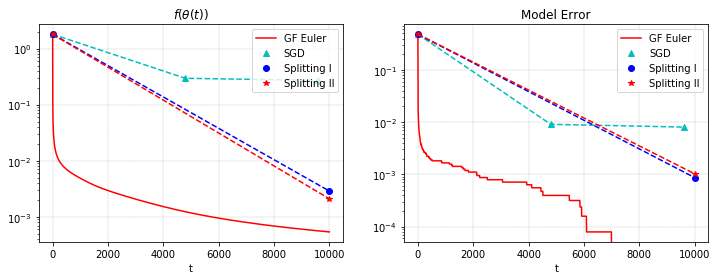

In [81]:
from scipy.interpolate import make_interp_spline, BSpline

# # 300 represents number of points to make between x.min and x.max
# print('🤓 Spline interpolation for GF')
# x_gf = ts_gf
# y_gf = losses_gf

# xnew = np.linspace(min(x_gf), max(x_gf), 20) 

# spl_gf = make_interp_spline(x_gf, y_gf, k=3)
# y_gf_smooth = spl_gf(xnew)

# print('🤓 Spline interpolation for SGD')
# x_sgd = ts_sgd
# y_sgd = losses_sgd

# spl_sgd = make_interp_spline(x_sgd, y_sgd, k=3)
# y_sgd_smooth = spl_sgd(xnew)

# print('🤓 Spline interpolation for Splitting I')
# x_spl = ts_spl
# y_spl = losses_spl

# spl_spl = make_interp_spline(x_spl, y_spl, k=3) 
# y_spl_smooth = spl_spl(xnew)

# print('🤓 Spline interpolation for Splitting II')
# x_spl = ts_spl
# y_spl = losses_spl2

# spl_spl = make_interp_spline(x_spl, y_spl, k=3)
# y_spl2_smooth = spl_spl(xnew)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# axs[0].semilogy(ts_gf,      losses_gf, 'g', label = 'GF')
axs[0].semilogy(ts_gf_eu,   losses_gf_eu, 'r', label = 'GF Euler')
axs[0].semilogy(ts_sgd,     losses_sgd, 'c^', label = 'SGD')
axs[0].semilogy(ts_sgd,     losses_sgd, 'c--')
axs[0].semilogy(ts_spl,     losses_spl, 'bo', label = 'Splitting I')
axs[0].semilogy(ts_spl,     losses_spl, 'b--')
axs[0].semilogy(ts_spl,     losses_spl2, 'r*', label = 'Splitting II')
axs[0].semilogy(ts_spl,     losses_spl2, 'r--')
axs[0].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[0].set_xlabel('t')
axs[0].set_title(r'$f\left(\theta(t)\right)$')
axs[0].legend()

axs[1].semilogy(ts_gf_eu[::10], errors_gf_eu, 'r', label = 'GF Euler')
axs[1].semilogy(ts_sgd, errors_sgd, 'c^', label = 'SGD')
axs[1].semilogy(ts_sgd, errors_sgd, 'c--')
axs[1].semilogy(ts_spl, errors_spl, 'bo', label = 'Splitting I')
axs[1].semilogy(ts_spl, errors_spl, 'b--')
axs[1].semilogy(ts_spl, errors_spl2, 'r*', label = 'Splitting II')
axs[1].semilogy(ts_spl, errors_spl2, 'r--')
axs[1].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[1].set_xlabel('t')
axs[1].set_title(r'Model Error')
axs[1].legend()

# axs[1].semilogy(xnew[1:], np.abs(np.array(y_sgd_smooth[1:]) - np.array(y_gf_smooth[1:])), 'c^', label = 'SGD')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_sgd_smooth[1:]) - np.array(y_gf_smooth[1:])), 'c--')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl_smooth[1:]) - np.array(y_gf_smooth[1:])), 'bo', label = 'Splitting I')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl_smooth[1:]) - np.array(y_gf_smooth[1:])), 'b--')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl2_smooth[1:]) - np.array(y_gf_smooth[1:])), 'r*', label = 'Splitting II')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl2_smooth[1:]) - np.array(y_gf_smooth[1:])), 'r--')
# axs[1].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
# axs[1].set_xlabel('t')
# axs[1].set_title(r'$\|f(\theta) - f(\theta_{GF})\|$')
# axs[1].legend()

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('ct_logreg.pdf')
plt.show()

In [65]:
errors_sgd

[0.4830994897959183, 0.005181760204081676, 0.0031887755102041337]

### Splitting by class

In [0]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from fastprogress.fastprogress import master_bar, progress_bar

# ======= Function definitions =======


def sigmoid(x):
    '''
    Calculates element-wise sigmoid function
    Parameters
    ----------
    x : array-like of floats
        Input vector (scalar)
    Returns
    -------
    sigma(x) : array-like of floats
        1/(1 + exp(-x_i)) for each x_i in x
    '''
    if np.isscalar(x):
        return 1/(1 + np.exp(-x))
    else:
        return np.array([1/(1 + np.exp(-x_i)) for x_i in x])

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    eta_0 = Q.T@theta_0
    def rhs(eta, t):
        return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
    eta_h = odeint(rhs, eta_0, h_seq)[-1]

    theta = Q@(eta_h - eta_0) + theta_0
    return theta

# def gradient(X, theta, y):
#     n, p = X.shape
#     return 1/n* X.T @ (sigmoid(X @ theta) - y)

# def make_SGD_step(X_batch, theta_0, y_batch, lr):
#     theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
#     return theta


def loss_logreg(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    This version is already normalized (1/n)
    '''
    if len(X.shape) == 2:
        y_pred = [sigmoid(theta.T @ x) for x in X]
        y_true = y
        return log_loss(y_true, y_pred, normalize = True)
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s

        loss = 0
        for i_batch in range(s):
            y_pred = [sigmoid(theta.T @ x) for x in Xs[i_batch]]
            y_true = ys[i_batch]
            loss += 1/n*log_loss(y_true, y_pred, normalize = False)
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')

def generate_problem_logistic_regression(class_splitting=False):
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
    y_train.view(-1).long()

    indicies0 = y_train == 0
    indicies1 = y_train == 1
    if class_splitting:
        return np.concatenate(X_train[indicies0], X_train[indicies1]), np.concatenate(y_train[indicies0], y_train[indicies1])
    else:
        return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

def gradient_flow_trajectory(Q, R, theta_0, y, ts):
    p, n = R.shape
    print(n)
    print('🤖 GF trajectory started')
    thetas = []
    losses = []
    theta_t = theta_0

    for t in progress_bar(ts):
        # This is not splitting, actually, since we use the whole sample as a 
        # batch. It is ODEint solution of the whole ODE
        theta_t = make_splitting_step(Q, R, theta_t, y, t, n)
        thetas.append(theta_t)
        loss_t = loss_logreg(R.T@Q.T, theta_t, y)
        losses.append(loss_t)
    
    print('🤖 GF trajectory finished')

    return thetas, losses

def gradient_flow_euler_trajectory(X, theta_0, y, lr, N_epoch, model):
    print('🤖 GF Euler trajectory started')
    n, p = X.shape
    thetas = []
    losses = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr
        t+= h 
        # X_batch = torch.from_numpy(X).float()
        # y_batch = torch.from_numpy(y).float()
        X, y = X.float(), y.float()
        
        model.zero_grad()
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred.view(-1), y.view(-1))
        ts.append(t)
        thetas.append(theta_t)
        losses.append(loss.data)
        # Backward pass
        loss.backward()
        for parameter in model.parameters():
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array(parameter.data[0].T)
            break
            # theta_t = np.array(parameter.data[0].T)

    thetas.append(theta_t)
    losses.append(loss.data)  
    
    print('🤖 GF Euler trajectory finished')

    return thetas, losses, ts

def sgd_trajectory(Xs, theta_0, ys, lr, N_epoch, model):
    print('🤖 SGD trajectory started')
    s, b, p = Xs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr*n/b
        t+=h
        ts.append(t)
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)

        for i_batch in range(s):
            X_batch = torch.from_numpy(Xs[i_batch]).float()
            y_batch = torch.from_numpy(ys[i_batch]).float()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred.view(-1), y_batch.view(-1))
            # Backward pass
            loss.backward()
            for parameter in model.parameters():
                parameter.data = parameter.data - lr*parameter.grad.data
                theta_t = np.array(parameter.data[0].T)
                break
            # theta_t = np.array(parameter.data[0].T)

    thetas.append(theta_t)
    loss_t = loss_logreg(Xs, theta_t, ys)
    losses.append(loss_t)  
    
    print('🤖 SGD trajectory finished')

    return thetas, losses, ts

def spl_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting I trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h, n)       
    
    print('🤖 Splitting I trajectory finished')

    return thetas, losses

def spl2_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting II trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s-1):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
        
        theta_t = make_splitting_step(Qs[s-1], Rs[s-1], theta_t, ys[s-1], h, n)

        for j_batch in range(s-1):
            i_batch = s - (j_batch + 2) 
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
    
    print('🤖 Splitting II trajectory finished')

    return thetas, losses

# ======= Problem generation =======

p = 784
n = 12665
b = 64
s = n//b

total_time  = 10
learning_rate = 1e-3
h_size = 0.3
N_epochs            = int(total_time*b/(learning_rate*n))
N_cycles            = int(total_time/(h_size))
N_gf_euler_steps    = int(total_time/learning_rate)
print('🤓 Number of SGD epochs: {}, Number of Splitting cycles: {}'.format(N_epochs, N_cycles))
print('🤓 Number of GD steps (Euler GF approximation) {}'.format(N_gf_euler_steps))
ts_gf  = np.linspace(0, total_time, N_cycles)
ts_spl = np.linspace(0, total_time, N_cycles)

X, y = generate_problem_logistic_regression()
print('🤓 Data loaded')
theta_0 = np.random.randn(p)

model = LogisticRegression()
criterion = nn.BCELoss(reduction = 'mean')
print('🤓 Model loaded')

Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('🤓 QR finished')

# ======= Trajectory generation =======
thetas_gf_eu, losses_gf_eu, ts_gf_eu    = gradient_flow_euler_trajectory(X, theta_0, y, learning_rate, N_gf_euler_steps, model)
# thetas_spl2, losses_spl2                = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_spl, losses_spl                  = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_sgd, losses_sgd, ts_sgd          = sgd_trajectory(Xs, theta_0, ys, learning_rate, N_epochs, model)
thetas_gf, losses_gf                    = gradient_flow_trajectory(Q, R, theta_0, y, ts_gf)

# thetas_spl, losses_spl = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_spl2, losses_spl2 = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)

IndentationError: ignored

# Softmax regression

In [173]:
# ======= Libraries =======

import math
import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint, solve_ivp
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from tqdm import tqdm
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
import copy
from fastprogress.fastprogress import master_bar, progress_bar
import random
# Reproducibility
random.seed(999)
np.random.seed(999)
torch.manual_seed(999)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ======= Function definitions =======

def load_batched_data(batch_size=50, shuffle = True, qr_mode = False):
    '''
    Load batches of MNIST data.

    Output: X_trains - s_train batches of training data, 
            y_trains - s_train batches of labels,
            X_test - test points
            y_test - test labels
    X_trains: torch.array of shape (s_train,batch_size,*X_train[0].shape),
        where 
        s_train - the number of batches, 
        batch_size - batch size
        *X_train[0].shape - shape of the dataset point;

    y_trains: torch.array of shape (s_train, K, batch_size),
        where
        K - the number of classes in the problem;

    X_test: torch.array of shape (n_test,*X_train[0].shape),
        where
        n_test - the number of test points;

    y_test: torch.array of shape (K, n_test);
    '''
    number_of_classes = 10
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    mask    = y_train < number_of_classes
    X_train = X_train[mask]
    y_train = y_train[mask]
    X_train.resize_(len(X_train), *X_train[0].view(-1).shape)
    y_train.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_train))
        X_train = X_train[shuffling]
        y_train = y_train[shuffling]

    # Download and load the test data
    testset = datasets.MNIST('./mnist_data/', download=True, train=False)
    X_test = testset.data.to(dtype=torch.float)/255
    y_test = testset.targets
    mask   = y_test < number_of_classes
    X_test = X_test[mask]
    y_test = y_test[mask]
    X_test.resize_(len(X_test), *X_test[0].view(-1).shape)
    y_test.view(-1).long()

    if shuffle == True:
        shuffling = torch.randperm(len(y_test))
        X_test = X_test[shuffling].to(device)
        y_test = y_test[shuffling]

    n_train = len(y_train)
    n_test  = len(y_test)

    s_train = int(n_train/batch_size)   # Number of training batches

    K           = number_of_classes 
    X_trains    = torch.zeros((s_train, batch_size, *X_train[0].view(-1).shape), requires_grad=False).to(device)
    y_trains    = torch.zeros((s_train, K, batch_size), requires_grad=False, dtype=torch.int64).to(device)
    if qr_mode:
        Qs      = torch.zeros((s_train, *X_train[0].view(-1).shape, batch_size), requires_grad=False).to(device)
        Rs      = torch.zeros((s_train, batch_size, batch_size), requires_grad=False).to(device)
        print('🤖QR started')

    y_test_one_hot = torch.zeros((n_test, K))
    y_test_one_hot[np.arange(n_test), y_test] = 1
    y_test_one_hot = y_test_one_hot.T

    for i in range(s_train):
        X_trains[i] = X_train[batch_size*i:batch_size*(i+1), :]
        batch_lbls  = y_train[batch_size*i:batch_size*(i+1)]
        y_batch_one_hot = torch.zeros((batch_size, K))
        y_batch_one_hot[np.arange(batch_size), batch_lbls] = 1
        y_trains[i] = y_batch_one_hot.T
        if qr_mode:
            Qs[i], Rs[i] = torch.qr(X_trains[i].T)      

    if qr_mode:
        print('✅QR computed')
        return X_trains, y_trains, X_test, y_test_one_hot, Qs, Rs
    else:
        return X_trains, y_trains, X_test, y_test_one_hot


# def softmax(x):
#     '''
#     Calculates column-wise softmax function
#     Parameters
#     ----------
#     x : array-like of floats
#         Input vector of shape K x 1 (matrix of shape K x b)
#     Returns
#     -------
#     sigma(x) : array-like of floats of the same shape as input
#         exp(x_i)/(sum(exp(x))) for each x_i in x
#     '''
#     if x.ndim == 1:
#         s = torch.nn.Softmax()
#         return s(x)
#     elif x.ndim == 2:
#         s = torch.nn.Softmax(dim=0)
#         return s(x)

def softmax_numpy(X):
    return np.array([np.exp(x)/sum(np.exp(x)) for x in X.T]).T

class CrossEntropyLoss_one_hot(nn.CrossEntropyLoss):
    '''
    Slightly modified version of the original CrossEntropyLoss in order to
    handle one-hot encodings
    '''
    def forward(self, input, target):
        target = torch.squeeze(torch.max(target, 1, keepdim=True)[1])
        return F.cross_entropy(input, target, weight=self.weight,
                                ignore_index=self.ignore_index, reduction=self.reduction)

def full_problem_from_batches(Xs, ys):
    s_train, batch_size, p = Xs.shape
    s_train, K, batch_size = ys.shape
    X = torch.zeros(s_train*batch_size, p)
    y = torch.zeros(K, s_train*batch_size)
    for i_batch in range(s_train):
        X[batch_size*i_batch:batch_size*(i_batch+1), :] = Xs[i_batch]
        y[:, batch_size*i_batch:batch_size*(i_batch+1)] = ys[i_batch]
    return X, y

def model_init(model, parameters_tensor):
    new_model = copy.deepcopy(model)
    for parameter in new_model.parameters():
        parameter.data = torch.tensor(parameters_tensor).to(device)
        # We won't update bias during the training, since they are not affect the model predictions
        break
    return new_model

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(int(input_dim), int(output_dim))
    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        out = F.softmax(self.linear(x), dim=1)
        return out

def load_model(X_test, y_test):
    '''
    Returns logistic regression model
    Which is just single linear layer with flattening at the beginning and softmax at the end
    '''
    input_dim = X_test[0].numel()
    K, n_test = y_test.shape

    model = LogisticRegression(input_dim, K)
    return model

def gradient_flow_euler_trajectory(theta_0, X_trains, y_trains,  X_test, y_test, lr, N_epoch, model):
    print('🤖 GF Euler trajectory started')
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y = X.float(), y.float()
    n_train, p  = X.shape
    K, n_test   = y_test.shape
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = CrossEntropyLoss_one_hot()
    theta_t         = theta_0
    ts  = []
    t   = 0
    model = model_init(model, theta_0.T)
    for i_t in progress_bar(range(N_epoch)):
        h = lr
        
        model.zero_grad()
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred, y.T)
        
        if i_t %40 == 0:
            model.eval()

            thetas.append(theta_t)
            losses_train.append(loss.data)
            pred_labels         = torch.max(y_pred, 1, keepdim=True)[1]
            true_labels         = torch.max(y.T, 1, keepdim=True)[1]
            train_acc           = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
            errors_train.append(1 - train_acc) 
            y_pred_test         = model(X_test)
            loss_test           = criterion(y_pred_test, y_test.T)
            losses_test.append(loss_test.data)
            pred_labels_test    = torch.max(y_pred_test, 1, keepdim=True)[1]
            true_labels_test    = torch.max(y_test.T, 1, keepdim=True)[1]
            test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
            errors_test.append(1 - test_acc)
        # Backward pass
        t+= h 
        model.train()
        loss.backward()
        for parameter in model.parameters():
            # print(f'Par norm {torch.norm(parameter.data)} shape {parameter.data.shape}, grad norm {torch.norm(parameter.grad.data)}')
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array(parameter.data.T)
            break
            # theta_t = np.array(parameter.data[0].T)
        
    model.eval()
    ts.append(t)
    thetas.append(theta_t)
    losses_train.append(loss.data)
    pred_labels         = torch.max(y_pred, 1, keepdim=True)[1]
    true_labels         = torch.max(y.T, 1, keepdim=True)[1]
    train_acc           = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
    errors_train.append(1 - train_acc) 
    y_pred_test = model(X_test)
    loss_test   = criterion(y_pred_test, y_test.T)
    losses_test.append(loss_test.data)
    pred_labels_test    = torch.max(y_pred_test, 1, keepdim=True)[1]
    true_labels_test    = torch.max(y_test.T, 1, keepdim=True)[1]
    test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
    errors_test.append(1 - test_acc)
    
    print('🤖 GF Euler trajectory finished')

    return thetas, ts, losses_train,losses_test, errors_train, errors_test

def sgd_trajectory(theta_0, X_trains, y_trains,  X_test, y_test, lr, N_epoch, model):
    print('🤖 SGD trajectory started')
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y = X.float(), y.float()
    s_train, batch_size, p = X_trains.shape
    n_train, p  = X.shape
    K, n_test   = y_test.shape
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = CrossEntropyLoss_one_hot()
    theta_t         = theta_0
    ts  = []
    t   = 0
    model = model_init(model, theta_0.T)
    for i_t in progress_bar(range(N_epoch)):
        h = lr*n_train/batch_size
        
        # Evaluation pass
        model.eval()
        y_pred = model(X)
        loss = criterion(y_pred, y.T)
        ts.append(t)
        thetas.append(theta_t)
        losses_train.append(loss.data)
        pred_labels     = torch.max(y_pred, 1, keepdim=True)[1]
        true_labels     = torch.max(y.T, 1, keepdim=True)[1]
        train_acc       = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
        errors_train.append(1 - train_acc) 
        y_pred_test = model(X_test)
        loss_test   = criterion(y_pred_test, y_test.T)
        losses_test.append(loss_test.data)
        pred_labels_test    = torch.max(y_pred_test, 1, keepdim=True)[1]
        true_labels_test    = torch.max(y_test.T, 1, keepdim=True)[1]
        test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
        errors_test.append(1 - test_acc)

        # Backward pass
        t+= h 
        model.train()
        for i_batch in range(s_train):
            model.zero_grad()
            # Forward pass
            y_pred = model(X_trains[i_batch])
            loss = criterion(y_pred, y_trains[i_batch].T)
            loss.backward()
            for parameter in model.parameters():
                # print(f'Par norm {torch.norm(parameter.data)} shape {parameter.data.shape}, grad norm {torch.norm(parameter.grad.data)}')
                parameter.data = parameter.data - lr*parameter.grad.data
                theta_t = np.array(parameter.data.T)
                break
        
    model.eval()
    y_pred = model(X)
    loss = criterion(y_pred, y.T)
    ts.append(t)
    thetas.append(theta_t)
    losses_train.append(loss.data)
    pred_labels     = torch.max(y_pred, 1, keepdim=True)[1]
    true_labels     = torch.max(y.T, 1, keepdim=True)[1]
    train_acc       = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
    errors_train.append(1 - train_acc) 
    y_pred_test = model(X_test)
    loss_test   = criterion(y_pred_test, y_test.T)
    losses_test.append(loss_test.data)
    pred_labels_test    = torch.max(y_pred_test, 1, keepdim=True)[1]
    true_labels_test    = torch.max(y_test.T, 1, keepdim=True)[1]
    test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
    errors_test.append(1 - test_acc)
    
    print('🤖 SGD trajectory finished')

    return thetas, ts, losses_train,losses_test, errors_train, errors_test

def make_splitting_step(theta_0, Q, R, y, h, n_train):
    p, K = theta_0.shape
    p, batch_size = Q.shape
    R, y = np.array(R), np.array(y)
    h_seq = [0, h]
    theta_0 = np.array(theta_0)   
    H_0 = np.array(Q.T @ theta_0)
    H_0_vec = H_0.ravel('F')
    H_h = np.zeros((batch_size, K))

    def rhs_vec(H, t):
        H = H.reshape((batch_size, K), order='F')
        rhs = -1/n_train * R@(softmax_numpy(H.T@R) - y).T
        return rhs.ravel('F')
    
    H_h_vec = odeint(rhs_vec, H_0_vec, h_seq)[-1]
    H_h = H_h_vec.reshape((batch_size, K), order='F')

    # .flatten(order = 'F') #numpy.reshape(order = 'F')

    # for i_class in range(K):
    #     eta_0 = H_0[:, i_class]
    #     def rhs(eta, t):
    #         return -1/n_train * R@(softmax() - np.array(y))
    #     H_h[:, i_class] = odeint(rhs, eta_0, h_seq)[-1]
    theta = Q@(H_h - H_0) + theta_0
    # print(theta_0.shape, theta.shape)
    return theta

# def make_splitting_step(Q, R, theta_0, y, h, n):
#     h_seq = [0, h]
#     eta_0 = Q.T@theta_0
#     def rhs(eta, t):
#         return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
#     eta_h = odeint(rhs, eta_0, h_seq)[-1]

#     theta = Q@(eta_h - eta_0) + theta_0
#     return theta

def spl_trajectory(theta_0, Qs, Rs, X_trains, y_trains,  X_test, y_test, ts, model):
    print('🤖 Splitting I trajectory started')
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_trains, y_trains, X_test, y_test = X.float(), y.float(), X_trains.float(), y_trains.float(), X_test.float(), y_test.float()
    s_train, batch_size, p = X_trains.shape
    n_train, p  = X.shape
    K, n_test   = y_test.shape
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = CrossEntropyLoss_one_hot()
    theta_t         = theta_0
    model = model_init(model, theta_0.T)
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        
        # Evaluation pass
        model.eval()
        y_pred = model(X)
        loss = criterion(y_pred, y.T)
        thetas.append(theta_t)
        losses_train.append(loss.data)
        pred_labels         = torch.max(y_pred, 1, keepdim=True)[1]
        true_labels         = torch.max(y.T, 1, keepdim=True)[1]
        train_acc           = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
        errors_train.append(1 - train_acc) 
        y_pred_test         = model(X_test)
        loss_test           = criterion(y_pred_test, y_test.T)
        losses_test.append(loss_test.data)
        pred_labels_test    = torch.max(y_pred_test, 1, keepdim=True)[1]
        true_labels_test    = torch.max(y_test.T, 1, keepdim=True)[1]
        test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
        errors_test.append(1 - test_acc)

        if t == ts[-1]:
            break

        # Backward pass
        model.train()
        h = ts[i_t+1] - ts[i_t]
        # print(theta_t.dtype, theta_t.shape)
        for i_batch in range(s_train):
            theta_t = make_splitting_step(theta_t, Qs[i_batch], Rs[i_batch], y_trains[i_batch], h, n_train).to(dtype=torch.float)
        # print(theta_t.dtype, theta_t.shape)
        model = model_init(model, theta_t.T)

    print('🤖 Splitting I trajectory finished')

    return thetas, losses_train,losses_test, errors_train, errors_test

def spl2_trajectory(theta_0, Qs, Rs, X_trains, y_trains,  X_test, y_test, ts, model):
    print('🤖 Splitting II trajectory started')
    X, y        = full_problem_from_batches(X_trains, y_trains)
    X, y, X_trains, y_trains, X_test, y_test = X.float(), y.float(), X_trains.float(), y_trains.float(), X_test.float(), y_test.float()
    s_train, batch_size, p = X_trains.shape
    n_train, p  = X.shape
    K, n_test   = y_test.shape
    thetas      = []
    losses_train    = []
    errors_train    = []
    losses_test     = []
    errors_test     = []
    criterion       = CrossEntropyLoss_one_hot()
    theta_t         = theta_0
    model = model_init(model, theta_0.T)
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        
        # Evaluation pass
        model.eval()
        y_pred = model(X)
        loss = criterion(y_pred, y.T)
        thetas.append(theta_t)
        losses_train.append(loss.data)
        pred_labels         = torch.max(y_pred, 1, keepdim=True)[1]
        true_labels         = torch.max(y.T, 1, keepdim=True)[1]
        train_acc           = true_labels.eq(pred_labels.data).sum().to(dtype=torch.float)/len(true_labels)
        errors_train.append(1 - train_acc) 
        y_pred_test         = model(X_test)
        loss_test           = criterion(y_pred_test, y_test.T)
        losses_test.append(loss_test.data)
        pred_labels_test    = torch.max(y_pred_test, 1, keepdim=True)[1]
        true_labels_test    = torch.max(y_test.T, 1, keepdim=True)[1]
        test_acc            = true_labels_test.eq(pred_labels_test.data).sum().to(dtype=torch.float)/len(true_labels_test)
        errors_test.append(1 - test_acc)

        if t == ts[-1]:
            break

        # Backward pass
        model.train()
        h = ts[i_t+1] - ts[i_t]
        # print(theta_t.dtype, theta_t.shape)
        for i_batch in range(s_train-1):
            theta_t = make_splitting_step(theta_t, Qs[i_batch], Rs[i_batch], y_trains[i_batch], h/2, n_train).to(dtype=torch.float)

        theta_t = make_splitting_step(theta_t, Qs[s_train-1], Rs[s_train-1], y_trains[s_train-1], h, n_train).to(dtype=torch.float)

        for j_batch in range(s_train-1):
            i_batch = s_train - (j_batch + 2) 
            theta_t = make_splitting_step(theta_t, Qs[i_batch], Rs[i_batch], y_trains[i_batch], h/2, n_train).to(dtype=torch.float)

        model = model_init(model, theta_t.T)

    print('🤖 Splitting II trajectory finished')

    return thetas, losses_train,losses_test, errors_train, errors_test


# ======= Problem generation =======



batch_size = 64
X_trains, y_trains, X_test, y_test, Qs, Rs = load_batched_data(batch_size=batch_size, qr_mode = True)
s_train, batch_size, p = X_trains.shape # Yes, here we have bs the same as input parameter in the previous line.
n_train, K, n_test = s_train*batch_size, *y_test.shape

total_time      = 200
learning_rate   = 1e-2
h_size = 20
N_epochs            = int(total_time*batch_size/(learning_rate*n_train))
N_cycles            = int(total_time/(h_size))
N_gf_euler_steps    = int(total_time/learning_rate)
print('🤓 Number of SGD epochs: {}, Number of Splitting cycles: {}'.format(N_epochs, N_cycles))
print('🤓 Number of GD steps (Euler GF approximation) {}'.format(N_gf_euler_steps))
ts_gf  = np.linspace(0, total_time, N_cycles)
ts_spl = np.linspace(0, total_time, N_cycles)

# theta_0 = torch.randn(p, K)
# theta_0 = theta_0/(p*K)

# theta_0 = theta_to_save

init_bound = 1.0/math.sqrt(p)
theta_0 = init_bound*torch.randn(p, K)

print('🐱Data loaded')

model = load_model(X_test, y_test)
print('🐱Model loaded')

# thetas_gf_eu, ts_gf_eu, losses_train_gf_eu, losses_test_gf_eu, errors_train_gf_eu, errors_test_gf_eu = \
#     gradient_flow_euler_trajectory(theta_0, X_trains, y_trains,  X_test, y_test, lr=learning_rate, N_epoch=N_gf_euler_steps, model=model)
# thetas_sgd, ts_sgd, losses_train_sgd, losses_test_sgd, errors_train_sgd, errors_test_sgd = \
#     sgd_trajectory(theta_0, X_trains, y_trains,  X_test, y_test, lr=learning_rate, N_epoch=N_epochs, model=model)
thetas_spl, losses_train_spl, losses_test_spl, errors_train_spl, errors_test_spl = \
    spl_trajectory(theta_0, Qs, Rs, X_trains, y_trains,  X_test, y_test, ts_spl, model=model)
thetas_spl2, losses_train_spl2, losses_test_spl2, errors_train_spl2, errors_test_spl2 = \
    spl2_trajectory(theta_0, Qs, Rs, X_trains, y_trains,  X_test, y_test, ts_spl, model=model)


🤖QR started
✅QR computed
🤓 Number of SGD epochs: 21, Number of Splitting cycles: 10
🤓 Number of GD steps (Euler GF approximation) 20000
🐱Data loaded
🐱Model loaded
🤖 Splitting I trajectory started


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


🤖 Splitting I trajectory finished
🤖 Splitting II trajectory started


🤖 Splitting II trajectory finished


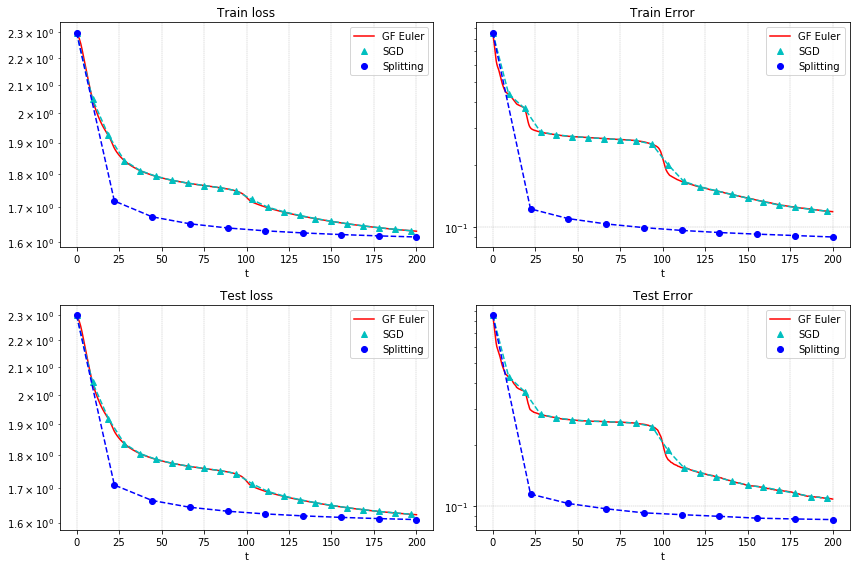

In [174]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# axs[0].semilogy(ts_gf,      losses_gf, 'g', label = 'GF')
axs[0, 0].semilogy(ts_gf_eu,   losses_train_gf_eu, 'r', label = 'GF Euler')
axs[0, 0].semilogy(ts_sgd,     losses_train_sgd, 'c^', label = 'SGD')
axs[0, 0].semilogy(ts_sgd,     losses_train_sgd, 'c--')
axs[0, 0].semilogy(ts_spl,     losses_train_spl, 'bo', label = 'Splitting')
axs[0, 0].semilogy(ts_spl,     losses_train_spl, 'b--')
# axs[0, 0].semilogy(ts_spl,     losses_train_spl2, 'g*', label = 'Splitting II')
# axs[0, 0].semilogy(ts_spl,     losses_train_spl2, 'g--')
axs[0, 0].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[0, 0].set_xlabel('t')
axs[0, 0].set_title(f'Train loss')
axs[0, 0].legend()

axs[0, 1].semilogy(ts_gf_eu, errors_train_gf_eu, 'r', label = 'GF Euler')
axs[0, 1].semilogy(ts_sgd, errors_train_sgd, 'c^', label = 'SGD')
axs[0, 1].semilogy(ts_sgd, errors_train_sgd, 'c--')
axs[0, 1].semilogy(ts_spl, errors_train_spl, 'bo', label = 'Splitting')
axs[0, 1].semilogy(ts_spl, errors_train_spl, 'b--')
# axs[0, 1].semilogy(ts_spl, errors_train_spl2, 'g*', label = 'Splitting II')
# axs[0, 1].semilogy(ts_spl, errors_train_spl2, 'g--')
axs[0, 1].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[0, 1].set_xlabel('t')
axs[0, 1].set_title(f'Train Error')
axs[0, 1].legend()

axs[1, 0].semilogy(ts_gf_eu,   losses_test_gf_eu, 'r', label = 'GF Euler')
axs[1, 0].semilogy(ts_sgd,     losses_test_sgd, 'c^', label = 'SGD')
axs[1, 0].semilogy(ts_sgd,     losses_test_sgd, 'c--')
axs[1, 0].semilogy(ts_spl,     losses_test_spl, 'bo', label = 'Splitting')
axs[1, 0].semilogy(ts_spl,     losses_test_spl, 'b--')
# axs[1, 0].semilogy(ts_spl,     losses_test_spl2, 'g*', label = 'Splitting II')
# axs[1, 0].semilogy(ts_spl,     losses_test_spl2, 'g--')
axs[1, 0].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[1, 0].set_xlabel('t')
axs[1, 0].set_title(f'Test loss')
axs[1, 0].legend()

axs[1, 1].semilogy(ts_gf_eu, errors_test_gf_eu, 'r', label = 'GF Euler')
axs[1, 1].semilogy(ts_sgd, errors_test_sgd, 'c^', label = 'SGD')
axs[1, 1].semilogy(ts_sgd, errors_test_sgd, 'c--')
axs[1, 1].semilogy(ts_spl, errors_test_spl, 'bo', label = 'Splitting')
axs[1, 1].semilogy(ts_spl, errors_test_spl, 'b--')
# axs[1, 1].semilogy(ts_spl, errors_test_spl2, 'g*', label = 'Splitting II')
# axs[1, 1].semilogy(ts_spl, errors_test_spl2, 'g--')
axs[1, 1].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[1, 1].set_xlabel('t')
axs[1, 1].set_title(f'Test Error')
axs[1, 1].legend()
fig.tight_layout()
# /content/drive/My Drive/Colab/Splitting
plt.savefig('/content/drive/My Drive/Colab/Splitting/nice_pic_mnist_free.pdf')

In [96]:

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    eta_0 = Q.T@theta_0
    def rhs(eta, t):
        return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
    eta_h = odeint(rhs, eta_0, h_seq)[-1]

    theta = Q@(eta_h - eta_0) + theta_0
    return theta


def loss_logreg(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    This version is already normalized (1/n)
    '''
    if len(X.shape) == 2:
        y_pred = [sigmoid(theta.T @ np.array(x)) for x in X]
        y_true = y
        return log_loss(y_true, y_pred, normalize = True)
    elif len(X.shape) == 3:
        s, b, p = X.shape
        n = b*s

        loss = 0
        for i_batch in range(s):
            y_pred = [sigmoid(theta.T @ np.array(x)) for x in X[i_batch]]
            y_true = y[i_batch]
            loss += 1/n*log_loss(y_true, y_pred, normalize = False)
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')    

def accuracy_of_model(X, y, theta):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        y_pred = [(sigmoid(theta.T @ np.array(x)) >= 0.5) for x in X]
        y_true = np.array(y)
        # print(type(y_pred), type(y_true))
        return(np.sum(y_pred == y_true)/len(y_true))
    elif len(X.shape) == 3:
        s, b, p = X.shape
        n = b*s

        correct = 0
        total   = 0
        for i_batch in range(s):
            y_pred = [(sigmoid(theta.T @ np.array(x)) >= 0.5) for x in X[i_batch]]
            y_true = np.array(y[i_batch])
            correct += np.sum(y_pred == y_true)
            total   += len(y_true)
        return correct/total
    else:
        raise ValueError('🤔 Inappropriate format of dataset')


   

def generate_problem_logistic_regression():
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
    y_train.view(-1).long()

    indicies0 = y_train == 0
    indicies1 = y_train == 1
    return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

def gradient_flow_trajectory(Q, R, theta_0, y, ts):
    p, n = R.shape
    print(n)
    print('🤖 GF trajectory started')
    thetas = []
    losses = []
    theta_t = theta_0

    for t in progress_bar(ts):
        # This is not splitting, actually, since we use the whole sample as a 
        # batch. It is ODEint solution of the whole ODE
        theta_t = make_splitting_step(Q, R, theta_t, y, t, n)
        thetas.append(theta_t)
        loss_t = loss_logreg(R.T@Q.T, theta_t, y)
        losses.append(loss_t)
    
    print('🤖 GF trajectory finished')

    return thetas, losses

def gradient_flow_euler_trajectory(X, theta_0, y, lr, N_epoch, model):
    print('🤖 GF Euler trajectory started')
    n, p = X.shape
    thetas = []
    losses = []
    errors = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr
        t+= h 
        # X_batch = torch.from_numpy(X).float()
        # y_batch = torch.from_numpy(y).float()
        X, y = X.float(), y.float()
        
        model.zero_grad()
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred.view(-1), y.view(-1))
        ts.append(t)
        thetas.append(theta_t)
        losses.append(loss.data)
        if i_t %10 == 0:
            errors.append(1- accuracy_of_model(X, y, theta_t))
        # Backward pass
        loss.backward()
        for parameter in model.parameters():
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array(parameter.data[0].T)
            break
            # theta_t = np.array(parameter.data[0].T)
        

    thetas.append(theta_t)
    losses.append(loss.data)  
    errors.append(1- accuracy_of_model(X, y, theta_t))
    
    print('🤖 GF Euler trajectory finished')

    return thetas, losses, ts, errors

def sgd_trajectory(Xs, theta_0, ys, lr, N_epoch, model):
    print('🤖 SGD trajectory started')
    s, b, p = Xs.shape
    n = b*s
    thetas = []
    losses = []
    errors = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr*n/b
        t+=h
        ts.append(t)
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)
        errors.append(1- accuracy_of_model(Xs, ys, theta_t))

        for i_batch in range(s):
            X_batch = torch.from_numpy(Xs[i_batch]).float()
            y_batch = torch.from_numpy(ys[i_batch]).float()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred.view(-1), y_batch.view(-1))
            # Backward pass
            loss.backward()
            for parameter in model.parameters():
                parameter_old = parameter.data
                parameter.data = parameter.data - lr*parameter.grad.data
                print(f'Diff {torch.norm(parameter.data - parameter_old)}')
                print(f'gradient {torch.norm(parameter.grad.data)}')
                theta_t = np.array(parameter.data[0].T)
                break
            # theta_t = np.array(parameter.data[0].T)

    thetas.append(theta_t)
    loss_t = loss_logreg(Xs, theta_t, ys)
    losses.append(loss_t)
    errors.append(1 - accuracy_of_model(Xs, ys, theta_t))  
    
    print('🤖 SGD trajectory finished')

    return thetas, losses, ts, errors

def spl_trajectory(Qs, Rs, theta_0, ys, ts, X, y):
    print('🤖 Splitting I trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    errors = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(X, theta_t, y)
        losses.append(loss_t)
        errors.append(1 - accuracy_of_model(X, y, theta_t))
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h, n)       
    
    print('🤖 Splitting I trajectory finished')

    return thetas, losses, errors

def spl2_trajectory(Qs, Rs, theta_0, ys, ts, X, y):
    print('🤖 Splitting II trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    errors = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(X, theta_t, y)
        losses.append(loss_t)
        errors.append(1 - accuracy_of_model(X, y, theta_t))
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s-1):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
        
        theta_t = make_splitting_step(Qs[s-1], Rs[s-1], theta_t, ys[s-1], h, n)

        for j_batch in range(s-1):
            i_batch = s - (j_batch + 2) 
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
    
    print('🤖 Splitting II trajectory finished')

    return thetas, losses, errors

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])


In [158]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

# Training settings
batch_size = 60000

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.softmax(self.l1(x))
        return x


model = Net()

theta_to_save = list(model.parameters())[0].data.T

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1, momentum=0)


def train(epoch, train_loss_):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_loss_.append(loss.item())
    return train_loss_


def test(test_loss_):
    
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_loss_.append(test_loss)
    return test_loss_

train_loss_ = []
test_loss_ = []
for epoch in range(1, 10):
    train_loss_ = train(epoch, train_loss_)
    test_loss_  = test(test_loss_)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299993


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 0.0002, Accuracy: 2961/10000 (30%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.287296

Test set: Average loss: 0.0002, Accuracy: 3707/10000 (37%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.270538

Test set: Average loss: 0.0002, Accuracy: 3777/10000 (38%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.247422

Test set: Average loss: 0.0002, Accuracy: 3866/10000 (39%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.221051

Test set: Average loss: 0.0002, Accuracy: 4729/10000 (47%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.195207

Test set: Average loss: 0.0002, Accuracy: 5496/10000 (55%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.166407

Test set: Average loss: 0.0002, Accuracy: 5814/10000 (58%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 2.134202

Test set: Average loss: 0.0002, Accuracy: 5959/10000 (60%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 2.100399

Test set: Average loss: 0.0002, Accuracy: 6082/10000 (61%)



In [166]:
errors_test_spl

[tensor(0.8586),
 tensor(0.1318),
 tensor(0.1159),
 tensor(0.1092),
 tensor(0.1043),
 tensor(0.1010),
 tensor(0.0987),
 tensor(0.0955),
 tensor(0.0938),
 tensor(0.0924),
 tensor(0.0911),
 tensor(0.0906),
 tensor(0.0892),
 tensor(0.0883),
 tensor(0.0879),
 tensor(0.0877),
 tensor(0.0873),
 tensor(0.0865),
 tensor(0.0861),
 tensor(0.0860)]

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [165]:
errors_test_spl2

[tensor(0.8586),
 tensor(0.1339),
 tensor(0.1170),
 tensor(0.1085),
 tensor(0.1041),
 tensor(0.1007),
 tensor(0.0982),
 tensor(0.0960),
 tensor(0.0941),
 tensor(0.0924),
 tensor(0.0915),
 tensor(0.0901),
 tensor(0.0890),
 tensor(0.0883),
 tensor(0.0883),
 tensor(0.0877),
 tensor(0.0869),
 tensor(0.0866),
 tensor(0.0860),
 tensor(0.0854)]